# End-to-End BraTS2020 **2D** Pipeline (Single Notebook)

This notebook trains a 2D U-Net for glioma segmentation from BraTS-style slice HDF5 files.

**Pipeline**
1. Group all `.h5` slices by patient (`volume_<vid>_slice_<sid>.h5`)
2. Patient-wise subset & train/val/test split (avoids leakage)
3. 2D preprocessing: drop all-zero masks, percentile normalization, center pad/crop
4. Train a small 2D U-Net (4-channel input → 1-channel tumor mask)
5. Plot training curves & qualitative overlays
6. Evaluate on test set: Dice / IoU / 2D-HD95 (per-slice) and aggregate per-volume
7. Export CSVs

**Assumptions about each `.h5` file**  
- Name: `volume_<vid>_slice_<sid>.h5`  
- Datasets:  
  - `image`: float array `[C, H, W]` (C=4 → T1, T1ce, T2, FLAIR)  
  - `mask` (or `label`/`labels`/`seg`/`gt`): uint8 `[H, W]` (binary)
Adjust the `read_h5()` function if your keys differ.

In [2]:
import os, re, random, h5py, numpy as np, pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from collections import defaultdict
from scipy.spatial.distance import cdist

DATA_ROOT = Path('./brats2020-training-data/BraTS2020_training_data/content/data')
OUTPUT_DIR = Path('./outputs_e2e2D'); OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

SUBSET_FRACTION = 0.5 # 0.5
SEED = 42
BATCH_SIZE = 4
EPOCHS = 50
LR = 1e-3
IMG_SIZE = (240, 240)
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
print(f'Using device: {DEVICE}')
print(f'Reading slices from: {DATA_ROOT.resolve()}')


Using device: cuda
Reading slices from: /home/holly520/Code_CSE/DIT698_DL/project/BraTS_hightlight/brats2020-training-data/BraTS2020_training_data/content/data


In [3]:
H5_RE = re.compile(r'^volume_(\d+)_slice_(\d+)\.h5$', re.IGNORECASE)

def group_by_volume(root: Path):
    groups = defaultdict(list)
    for p in root.glob('*.h5'):
        m = H5_RE.fullmatch(p.name)
        if not m:
            continue
        vid = int(m.group(1)); sid = int(m.group(2))
        groups[vid].append((sid, p.resolve()))
    grouped = {vid: [path for sid, path in sorted(items, key=lambda x: x[0])]
               for vid, items in sorted(groups.items(), key=lambda kv: kv[0])}
    return grouped

groups = group_by_volume(DATA_ROOT)
print(f'Found {len(groups)} patients. Example IDs:', list(groups.keys())[:8])
total_slices = sum(len(v) for v in groups.values())
print(f'Total slices discovered: {total_slices}')


Found 369 patients. Example IDs: [1, 2, 3, 4, 5, 6, 7, 8]
Total slices discovered: 57195


In [4]:
all_vids = list(groups.keys())
random.Random(SEED).shuffle(all_vids)
subset_n = max(1, int(len(all_vids) * SUBSET_FRACTION))
subset_vids = sorted(all_vids[:subset_n])

train_vids, test_vids = train_test_split(subset_vids, test_size=0.2, random_state=SEED)
train_vids, val_vids  = train_test_split(train_vids, test_size=0.2, random_state=SEED)

def gather_paths(vid_list):
    out = []
    for vid in vid_list:
        out.extend(groups[vid])
    return out

train_paths = gather_paths(train_vids)
val_paths   = gather_paths(val_vids)
test_paths  = gather_paths(test_vids)

print(f'Subset patients: {len(subset_vids)} | train: {len(train_vids)}, val: {len(val_vids)}, test: {len(test_vids)}')
print(f'Slices -> train: {len(train_paths)}, val: {len(val_paths)}, test: {len(test_paths)}')


Subset patients: 184 | train: 117, val: 30, test: 37
Slices -> train: 18135, val: 4650, test: 5735


In [5]:
import h5py, numpy as np

def read_h5(path: Path):
    """
    Expect:
      image: (H, W, 4) or (4, H, W)  -> returns (4, H, W) float32
      mask:  (H, W, 3) one-hot for (Necrosis, Edema, Enhancing)
             -> returns (H, W) int64 with labels: 0=BG, 1=Necrosis, 2=Edema, 3=Enhancing
    """
    with h5py.File(path, "r") as f:
        img = f["image"][()]
        # to channels-first (4, H, W)
        if img.ndim == 3 and img.shape[-1] in (3,4):
            img = np.moveaxis(img, -1, 0)
        elif img.ndim == 2:
            img = img[None, ...]
        elif img.ndim == 3 and img.shape[0] in (3,4):
            pass
        else:
            raise ValueError(f"Unexpected image shape: {img.shape}")

        m = f["mask"][()]  # (H, W, 3) one-hot
        if m.ndim != 3 or m.shape[-1] != 3:
            raise ValueError(f"Expect mask (H,W,3) one-hot, got {m.shape}")

        # background channel = 1 - any(foreground)
        bg = (m <= 0).all(axis=-1, keepdims=True).astype(np.uint8)  # (H,W,1)
        # stack as [BG, Necrosis, Edema, Enhancing]
        four = np.concatenate([bg, (m > 0).astype(np.uint8)], axis=-1)  # (H,W,4)
        # to class indices 0..3
        cls = np.argmax(four, axis=-1).astype(np.int64)  # (H,W)

        return img.astype(np.float32), cls  # (4,H,W), (H,W) int64


def percentile_normalize(img, lower=0.5, upper=99.5, eps=1e-6):
    # img: (C,H,W)
    out = np.empty_like(img, dtype=np.float32)
    for c in range(img.shape[0]):
        lo = np.percentile(img[c], lower); hi = np.percentile(img[c], upper)
        out[c] = np.clip((img[c]-lo)/(hi-lo+eps), 0, 1)
    return out

def _pad2d_or_3d(arr, ph, pw):
    if arr.ndim == 3:  # (C,H,W)
        return np.pad(arr, ((0,0),(ph//2, ph-ph//2),(pw//2, pw-pw//2)), mode="constant")
    if arr.ndim == 2:  # (H,W)
        return np.pad(arr, ((ph//2, ph-ph//2),(pw//2, pw-pw//2)), mode="constant")
    raise ValueError(f"Unsupported ndim={arr.ndim}")

def center_pad_crop(img, mask, size=(240,240)):
    H, W = img.shape[1], img.shape[2]; th, tw = size
    ph, pw = max(0, th-H), max(0, tw-W)
    if ph>0 or pw>0:
        img  = _pad2d_or_3d(img,  ph, pw)
        mask = _pad2d_or_3d(mask, ph, pw)
    H2, W2 = img.shape[1], img.shape[2]
    sy, sx = (H2-th)//2, (W2-tw)//2
    return img[:, sy:sy+th, sx:sx+tw], mask[sy:sy+th, sx:sx+tw]


In [6]:
from torch.utils.data import Dataset, DataLoader

class BraTS2DDatasetLazy(Dataset):
    """
    Lazy-loading dataset:
      - Keep only file paths in __init__
      - Read/normalize/pad-crop on-the-fly in __getitem__
      - Optionally drop slices whose mask is all background
    """
    def __init__(self, paths, drop_all_zero=True, size=(240, 240)):
        self.paths = list(paths)
        self.drop_all_zero = drop_all_zero
        self.size = size

    def __len__(self):
        return len(self.paths)

    def _load_one(self, p: Path):
        # read from disk
        img, cls = read_h5(p)                 # img: (4,H,W)  cls: (H,W) int
        # optional drop: keep only slices with any foreground
        if self.drop_all_zero and cls.max() == 0:
            return None
        # preprocessing
        img = percentile_normalize(img)
        img, cls = center_pad_crop(img, cls, size=self.size)
        # to tensors
        x = torch.from_numpy(img).float()     # (C,H,W)
        y = torch.from_numpy(cls).long()      # (H,W)
        return x, y, p.name.replace('.h5','')

    def __getitem__(self, idx):
        p = self.paths[idx]
        sample = self._load_one(p)

        # If this slice was dropped due to all-zero mask, fallback to a nearby one
        if sample is None:
            # linear probing to find the next valid slice
            j = (idx + 1) % len(self.paths)
            while True:
                sample = self._load_one(self.paths[j])
                if sample is not None or j == idx:
                    break
                j = (j + 1) % len(self.paths)

            # as a last resort (all zero), create a dummy empty slice (rare)
            if sample is None:
                img, cls = read_h5(self.paths[idx])
                img = percentile_normalize(img)
                img, cls = center_pad_crop(img, cls, size=self.size)
                sample = (torch.from_numpy(img).float(),
                          torch.from_numpy(cls).long(),
                          self.paths[idx].name.replace('.h5',''))

        return sample


num_workers = min(8, os.cpu_count() or 4)

train_ds = BraTS2DDatasetLazy(train_paths, drop_all_zero=True,  size=IMG_SIZE)
val_ds   = BraTS2DDatasetLazy(val_paths,   drop_all_zero=True,  size=IMG_SIZE)
test_ds  = BraTS2DDatasetLazy(test_paths,  drop_all_zero=False, size=IMG_SIZE)

common_kwargs = dict(num_workers=num_workers,
                     pin_memory=True,
                     persistent_workers=True,
                     prefetch_factor=2)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  **common_kwargs)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, **common_kwargs)
test_loader  = DataLoader(test_ds,  batch_size=1,          shuffle=False, **common_kwargs)


In [7]:
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.net(x)

class UNet2D(nn.Module):
    def __init__(self, in_ch=4, out_ch=1, base=32):
        super().__init__()
        self.d1 = DoubleConv(in_ch, base);  self.p1 = nn.MaxPool2d(2)
        self.d2 = DoubleConv(base, base*2); self.p2 = nn.MaxPool2d(2)
        self.d3 = DoubleConv(base*2, base*4); self.p3 = nn.MaxPool2d(2)
        self.d4 = DoubleConv(base*4, base*8)
        self.u3 = nn.ConvTranspose2d(base*8, base*4, 2, stride=2); self.ud3 = DoubleConv(base*8, base*4)
        self.u2 = nn.ConvTranspose2d(base*4, base*2, 2, stride=2); self.ud2 = DoubleConv(base*4, base*2)
        self.u1 = nn.ConvTranspose2d(base*2, base, 2, stride=2);   self.ud1 = DoubleConv(base*2, base)
        self.outc = nn.Conv2d(base, out_ch, 1)
    def forward(self, x):
        x1 = self.d1(x)
        x2 = self.d2(self.p1(x1))
        x3 = self.d3(self.p2(x2))
        x4 = self.d4(self.p3(x3))
        x = self.u3(x4); x = self.ud3(torch.cat([x, x3], dim=1))
        x = self.u2(x);  x = self.ud2(torch.cat([x, x2], dim=1))
        x = self.u1(x);  x = self.ud1(torch.cat([x, x1], dim=1))
        return self.outc(x)

model = UNet2D(in_ch=4, out_ch=4).to(DEVICE)
print(f'Model params: {sum(p.numel() for p in model.parameters())/1e6:.2f} M')


Model params: 1.93 M


In [8]:
ce = nn.CrossEntropyLoss()  # logits: (B,4,H,W); target: (B,H,W) long

def soft_dice_mc(logits, target, eps=1e-6):
    """
    Multiclass soft Dice averaged over foreground classes (1..3).
    logits: (B,C,H,W), target: (B,H,W) long in [0..C-1]
    """
    probs = torch.softmax(logits, dim=1)               # (B,C,H,W)
    onehot = torch.zeros_like(probs)                   # (B,C,H,W)
    onehot.scatter_(1, target.unsqueeze(1), 1)         # GT one-hot

    # foreground only
    p = probs[:, 1:, :, :]                             # (B,3,H,W)
    t = onehot[:, 1:, :, :]
    inter = (p * t).sum(dim=(2,3)) * 2                 # (B,3)
    den   = (p*p + t*t).sum(dim=(2,3)) + eps           # (B,3)
    dice_per_class = inter / den                       # (B,3)
    return 1.0 - dice_per_class.mean()                 # scalar loss

def criterion(logits, target):
    return 0.5 * ce(logits, target) + 0.5 * soft_dice_mc(logits, target)


def iou_score(pred, target, th=0.5, eps=1e-6):
    pred = (pred>th).astype(np.uint8); target = (target>0.5).astype(np.uint8)
    inter = (pred & target).sum(); union = (pred | target).sum()
    return (inter + eps) / (union + eps)

def hd95_binary(pred, target):
    pred = pred.astype(bool); target = target.astype(bool)
    if pred.sum()==0 and target.sum()==0: return 0.0
    if pred.sum()==0 or target.sum()==0: return float('inf')
    P = np.column_stack(np.nonzero(pred)); T = np.column_stack(np.nonzero(target))
    D1 = cdist(P, T).min(axis=1); D2 = cdist(T, P).min(axis=1)
    d = np.concatenate([D1, D2])
    return float(np.percentile(d, 95))


In [9]:
def fg_macro_dice_from_logits(logits, y, num_classes=4, eps=1e-6):
    """
    logits: (B,C,H,W), y: (B,H,W) long
    return: scalar macro dice over classes 1..C-1
    """
    with torch.no_grad():
        pred = torch.argmax(logits, dim=1)          # (B,H,W)
        dices = []
        for c in range(1, num_classes):
            p = (pred == c).float()
            t = (y    == c).float()
            inter = (p*t).sum(dim=(1,2)) * 2
            den   = (p*p + t*t).sum(dim=(1,2)) + eps
            dices.append(inter / den)
        return torch.stack(dices, 0).mean().item()

# validation loop example
def validate(loader):
    model.eval(); total_loss, total_dice, n = 0.0, 0.0, 0
    with torch.no_grad():
        for x, y, _ in loader:
            x = x.to(DEVICE); y = y.to(DEVICE)
            logits = model(x)
            loss = criterion(logits, y)
            total_loss += loss.item() * x.size(0); n += x.size(0)
            total_dice += fg_macro_dice_from_logits(logits, y) * x.size(0)
    return total_loss/max(1,n), total_dice/max(1,n)

In [ ]:
history = {'epoch':[], 'train_loss':[], 'val_loss':[], 'val_dice':[]}

optimizer = torch.optim.Adam(model.parameters(), lr=LR)

def run_epoch(loader, train=True):
    total_loss, n = 0.0, 0
    model.train() if train else model.eval()
    for x, y, _ in loader:
        x = x.to(DEVICE); y = y.to(DEVICE)          # y: (B,H,W) long
        with torch.set_grad_enabled(train):
            logits = model(x)                       # (B,4,H,W)
            loss = criterion(logits, y)
            if train:
                optimizer.zero_grad(); loss.backward(); optimizer.step()
        total_loss += loss.item() * x.size(0); n += x.size(0)
    return total_loss / max(1, n)



# best_val = 1e9
best_val = float('inf')
for ep in range(1, EPOCHS+1):
    tr = run_epoch(train_loader, train=True)
    va, vd = validate(val_loader)                

    history['epoch'].append(ep)
    history['train_loss'].append(tr)
    history['val_loss'].append(va)
    history['val_dice'].append(vd)

    print(f"[{ep:03d}] train_loss={tr:.4f}  val_loss={va:.4f}  val_dice={vd:.4f}")

    if va < best_val:
        best_val = va
        torch.save(model.state_dict(), OUTPUT_DIR/'unet2d_best.pt')
        print("  saved best ckpt")

# save history
import json
with open(OUTPUT_DIR/'unet2d_training_history.json', 'w') as f:
    json.dump(history, f)

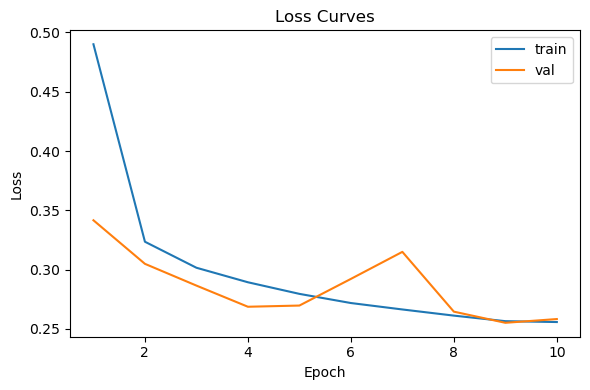

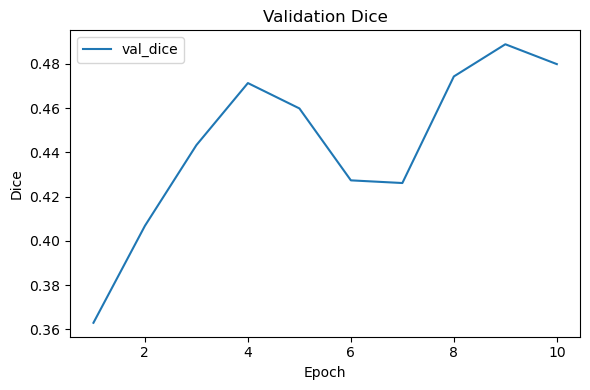

In [ ]:
plt.figure(figsize=(6,4)); plt.plot(history['epoch'], history['train_loss'], label='train')
plt.plot(history['epoch'], history['val_loss'], label='val'); plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.title('Loss Curves'); plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(6,4)); plt.plot(history['epoch'], history['val_dice'], label='val_dice')
plt.xlabel('Epoch'); plt.ylabel('Dice'); plt.title('Validation Dice'); plt.legend(); plt.tight_layout(); plt.show()




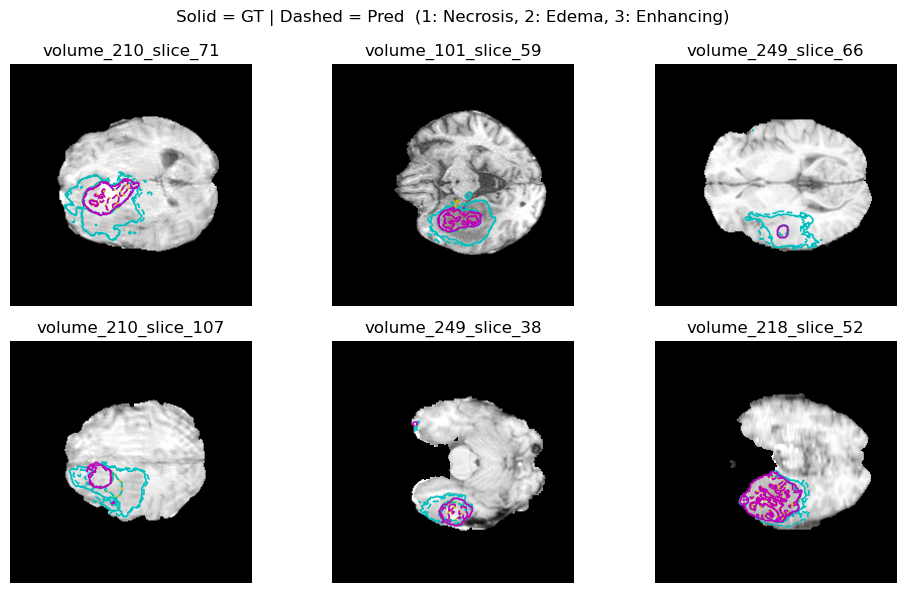

In [ ]:
model.load_state_dict(torch.load(OUTPUT_DIR/'unet2d_best.pt', map_location=DEVICE))
model.eval()

rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=(10, 6))
axes = axes.ravel()

# colors per class: 1=Necrosis, 2=Edema, 3=Enhancing
colors = {1: 'y', 2: 'c', 3: 'm'}          # GT: solid
pred_linestyle = 'dashed'                  # pred: virtual dashed

with torch.no_grad():
    for i in range(rows * cols):
        import numpy as _np
        idx = _np.random.randint(len(val_ds))
        x, y, name = val_ds[idx]           # x: (C,H,W), y: (H,W) long
        logits = model(x[None].to(DEVICE)) # (1,4,H,W)

        # ---- multiclass prediction
        pred = torch.argmax(torch.softmax(logits, dim=1), dim=1)[0].cpu().numpy()  # (H,W)
        gt   = y.cpu().numpy()                                                    # (H,W)

        # choose a background image to show (e.g., T1Gd)
        base = x.numpy()[1] if x.shape[0] > 1 else x.numpy()[0]
        axes[i].imshow(base, cmap='gray')

        # draw GT (solid) and Pred (dashed) contours for each foreground class
        for c in (1, 2, 3):
            axes[i].contour((gt == c).astype(np.uint8), levels=[0.5],
                            colors=colors[c], linewidths=1.2)
            axes[i].contour((pred == c).astype(np.uint8), levels=[0.5],
                            colors=colors[c], linewidths=1.2, linestyles=pred_linestyle)

        axes[i].set_title(name); axes[i].axis('off')

plt.suptitle("Solid = GT | Dashed = Pred  (1: Necrosis, 2: Edema, 3: Enhancing)")
plt.tight_layout(); plt.show()


In [ ]:
import numpy as np
import pandas as pd
import re
import torch

def dice_iou_binary(p, t, eps=1e-6):
    inter = (p & t).sum()
    union = (p | t).sum()
    dice = (2*inter + eps) / (p.sum() + t.sum() + eps)
    iou  = (inter + eps) / (union + eps)
    return float(dice), float(iou)

def evaluate_multiclass(
    loader,
    model,
    device="cpu",
    num_classes=4,
    add_overall_mean: bool = True,
    overall_label: str = "Overall_Mean",
    save_csv_dir = None,                  # e.g., OUTPUT_DIR Path; saves 2 CSVs if not None
):
    """
    Evaluate a multiclass model on a DataLoader.

    Returns:
      per_slice_df : metrics per slice
      per_vol_df   : metrics aggregated per volume (with an extra 'Overall_Mean' row if add_overall_mean=True)
      overall_row  : dict of overall mean metrics (or None if add_overall_mean=False)
    """
    model.eval()
    rows = []
    with torch.no_grad():
        for x, y, name in loader:
            x = x.to(device)        # (1, C, H, W)
            y = y.to(device)        # (1, H, W) long
            logits = model(x)       # (1, num_classes, H, W)

            pred = torch.argmax(torch.softmax(logits, dim=1), dim=1)[0].cpu().numpy()
            gt   = y[0].cpu().numpy()

            metrics = {"id": name[0]}
            dices, ious = [], []
            for c, cname in zip([1, 2, 3], ["Necrosis", "Edema", "Enhancing"]):
                p = (pred == c).astype(np.uint8)
                t = (gt   == c).astype(np.uint8)
                d, i = dice_iou_binary(p, t)
                metrics[f"dice_{cname}"] = d
                metrics[f"iou_{cname}"]  = i
                dices.append(d); ious.append(i)

            metrics["dice_FG_mean"] = float(np.mean(dices))
            metrics["iou_FG_mean"]  = float(np.mean(ious))
            rows.append(metrics)

    per_slice_df = pd.DataFrame(rows)

    # ---- aggregate per volume
    def volid(s):
        m = re.match(r"(volume_\d+)_slice_\d+$", s)
        return m.group(1) if m else s

    per_slice_df["volume_id"] = per_slice_df["id"].map(volid)
    per_vol_df = per_slice_df.groupby("volume_id", as_index=False).mean(numeric_only=True)

    overall_row = None
    if add_overall_mean and len(per_vol_df) > 0:
        # compute overall mean across all numeric columns
        overall_row = per_vol_df.mean(numeric_only=True).to_dict()
        overall_row["volume_id"] = overall_label
        # append as the last row
        per_vol_df = pd.concat([per_vol_df, pd.DataFrame([overall_row])], ignore_index=True)

    # optional: save CSVs
    if save_csv_dir is not None:
        (save_csv_dir / "metrics_mc_per_slice.csv").write_text(per_slice_df.to_csv(index=False))
        (save_csv_dir / "metrics_mc_per_volume.csv").write_text(per_vol_df.to_csv(index=False))

    return per_slice_df, per_vol_df, overall_row



per_slice_df, per_vol_df, overall = evaluate_multiclass(
    test_loader, model, device=DEVICE, add_overall_mean=True, save_csv_dir=OUTPUT_DIR
)

print("Overall mean row:")
print(overall)          # {'dice_Necrosis':..., 'dice_Edema':..., ..., 'volume_id':'Overall_Mean'}
display(per_vol_df.tail(3))  # Overall_Mean


Overall mean row:
{'dice_Necrosis': 0.39369702915473714, 'iou_Necrosis': 0.37546546022044, 'dice_Edema': 0.33572196969994267, 'iou_Edema': 0.28123445982858486, 'dice_Enhancing': 0.3489817083552517, 'iou_Enhancing': 0.3201919984966044, 'dice_FG_mean': 0.35946690240331053, 'iou_FG_mean': 0.32563063951520976, 'volume_id': 'Overall_Mean'}


,volume_id,dice_Necrosis,iou_Necrosis,dice_Edema,iou_Edema,dice_Enhancing,iou_Enhancing,dice_FG_mean,iou_FG_mean
6,volume_298,0.160662,0.152040,0.225549,0.181728,0.110216,0.109947,0.165476,0.147905
7,volume_361,0.164764,0.163172,0.301313,0.241738,0.574944,0.574580,0.347007,0.326496
8,Overall_Mean,0.393697,0.375465,0.335722,0.281234,0.348982,0.320192,0.359467,0.325631
